# Furniture classification

## Benchmark model (Vanilla)

In this notebook a Convolutional Network to classify furnitures from images is build and trained from scratch (without any use of pre-trained models). This model aims to serve as benchmark of the other model of this project.


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import utilities.training as training
import utilities.visuals as visuals
import utilities.data as data

Using TensorFlow backend.


# Reading the dataset

There are three datasets available varying in size. The amount of classes of each label are balanced regardless the size of the dataset.

Please, check README for links to download the datasets. Unzip them into `datasets` directory.

In [4]:
!cat README.TXT

Furniture Classification
------------------------

Below you find links to download the datasets used in this project.
Download and unzip them into `datasets` directory.

1000 images:
https://s3-sa-east-1.amazonaws.com/tm-capstone/dataset_1000.zip

2500 images:
https://s3-sa-east-1.amazonaws.com/tm-capstone/dataset_2500.zip

5000 images:
https://s3-sa-east-1.amazonaws.com/tm-capstone/dataset_5000.zip



In [5]:
!ls datasets

dataset_1000


In [6]:
image_dataset = data.ImageDataset.load('datasets/dataset_1000')

### Preparing the train, test and and validation datasets

In [7]:
USE_GENERATOR = False

In [8]:
X = image_dataset.as_paths() if USE_GENERATOR else image_dataset.as_tensors()

100%|██████████| 1000/1000 [00:07<00:00, 133.52it/s]


In [9]:
dataset = training.TrainTestDataset.split(X,
                                          image_dataset.as_targets(),
                                          test_size=.1,
                                          valid_size=.25)

In [10]:
dataset.shape

((650, 224, 224, 3),
 (101, 224, 224, 3),
 (249, 224, 224, 3),
 (650, 5),
 (101, 5),
 (249, 5))

In [11]:
del X

# Building the Vanilla model

In [12]:
def get_vanilla_model(num_classes, input_shape=(224, 224, 3)):
    from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
    from keras.layers import Dropout, Flatten, Dense, Activation
    from keras.models import Sequential
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(1, 1)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(1, 1)))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [14]:
vanilla_model = get_vanilla_model(num_classes=image_dataset.classes)

In [15]:
vanilla_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 222, 222, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 108, 108, 128)     73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 108, 108, 128)     0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 128)               0         
__________

In [17]:
vanilla_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Training

Once the model is trained, the weights of the best model are saved at `weights.best.{model_name}.hdf5`.

In [18]:
model_name = 'vanilla'

In [19]:
trainer = training.Trainer(model_name, vanilla_model)

In [20]:
trained_model = trainer.train(dataset,
                              epochs=100,
                              batch_size=16, 
                              verbose=0,
                              verbose_checkpointer=0,
                              use_generator=USE_GENERATOR)

Training history plot

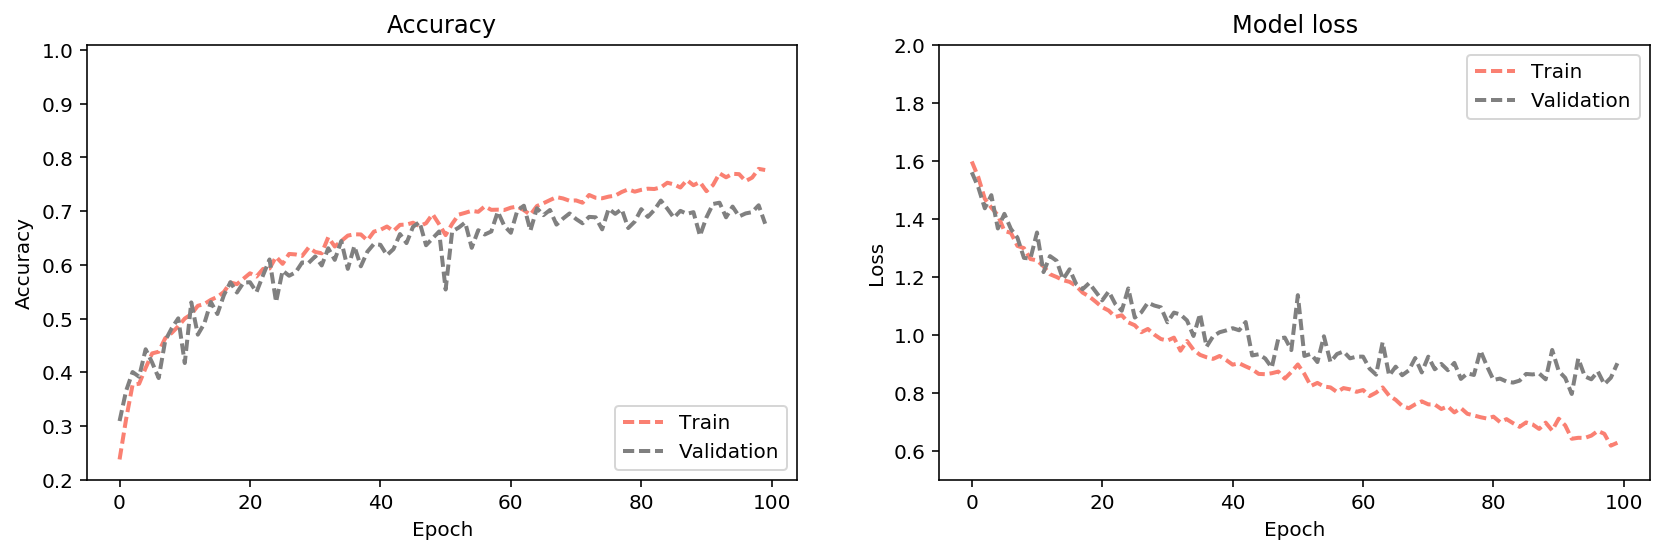

In [18]:
visuals.TrainPlotter(trained_model).plot_history(ylim1=(0.2, 1.01), ylim2=(0.5, 2.0))

# Evaluation

In [19]:
class_names = ['cup', 'desk', 'pillow', 'mug', 'table lamp']

### Testing

In [20]:
print('Test accuracy: %.4f%%' % trained_model.test(dataset.X_test, dataset.y_test))

Test accuracy: 70.8583%


### Softmax predictions

In [21]:
def _display_image_predictions(images, predictions):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    n_classes = 5
    fig, axies = plt.subplots(figsize=(12, 8), nrows=len(images), ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=16, y=1.1)

    n_predictions = 5
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (image_path, pred) in \
        enumerate(zip(images, predictions)):
        
        label_id = np.argmax(pred)
        label_name = class_names[label_id]
        
        pred_names = [class_names[pred_i] for pred_i, _ in enumerate(pred)]
        img = cv2.imread(image_path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axies[image_i][0].imshow(img)
        axies[image_i][0].set_title(label_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred, width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(class_names)
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [22]:
def _predict(X, name, model):
    import numpy as np
    import tensorflow as tf

    with tf.Session() as sess:
        model.load_weights('weights.best.{}.hdf5'.format(name))
        
        y_pred = np.array([
            model.predict(np.expand_dims(feature, axis=0))[0]
            for feature in X
        ])
    return y_pred

In [23]:
def random_predict_and_display(n):
    import random
    import numpy as np
    from utilities.data import paths_to_tensor
    indexes = random.sample(range(len(image_dataset)), n)
    tensors = paths_to_tensor(np.array(image_dataset.images)[indexes])
    predictions = _predict(tensors, model_name, vanilla_model)
    _display_image_predictions(
        np.array(image_dataset.images)[indexes], predictions
    )

100%|██████████| 5/5 [00:00<00:00, 111.39it/s]


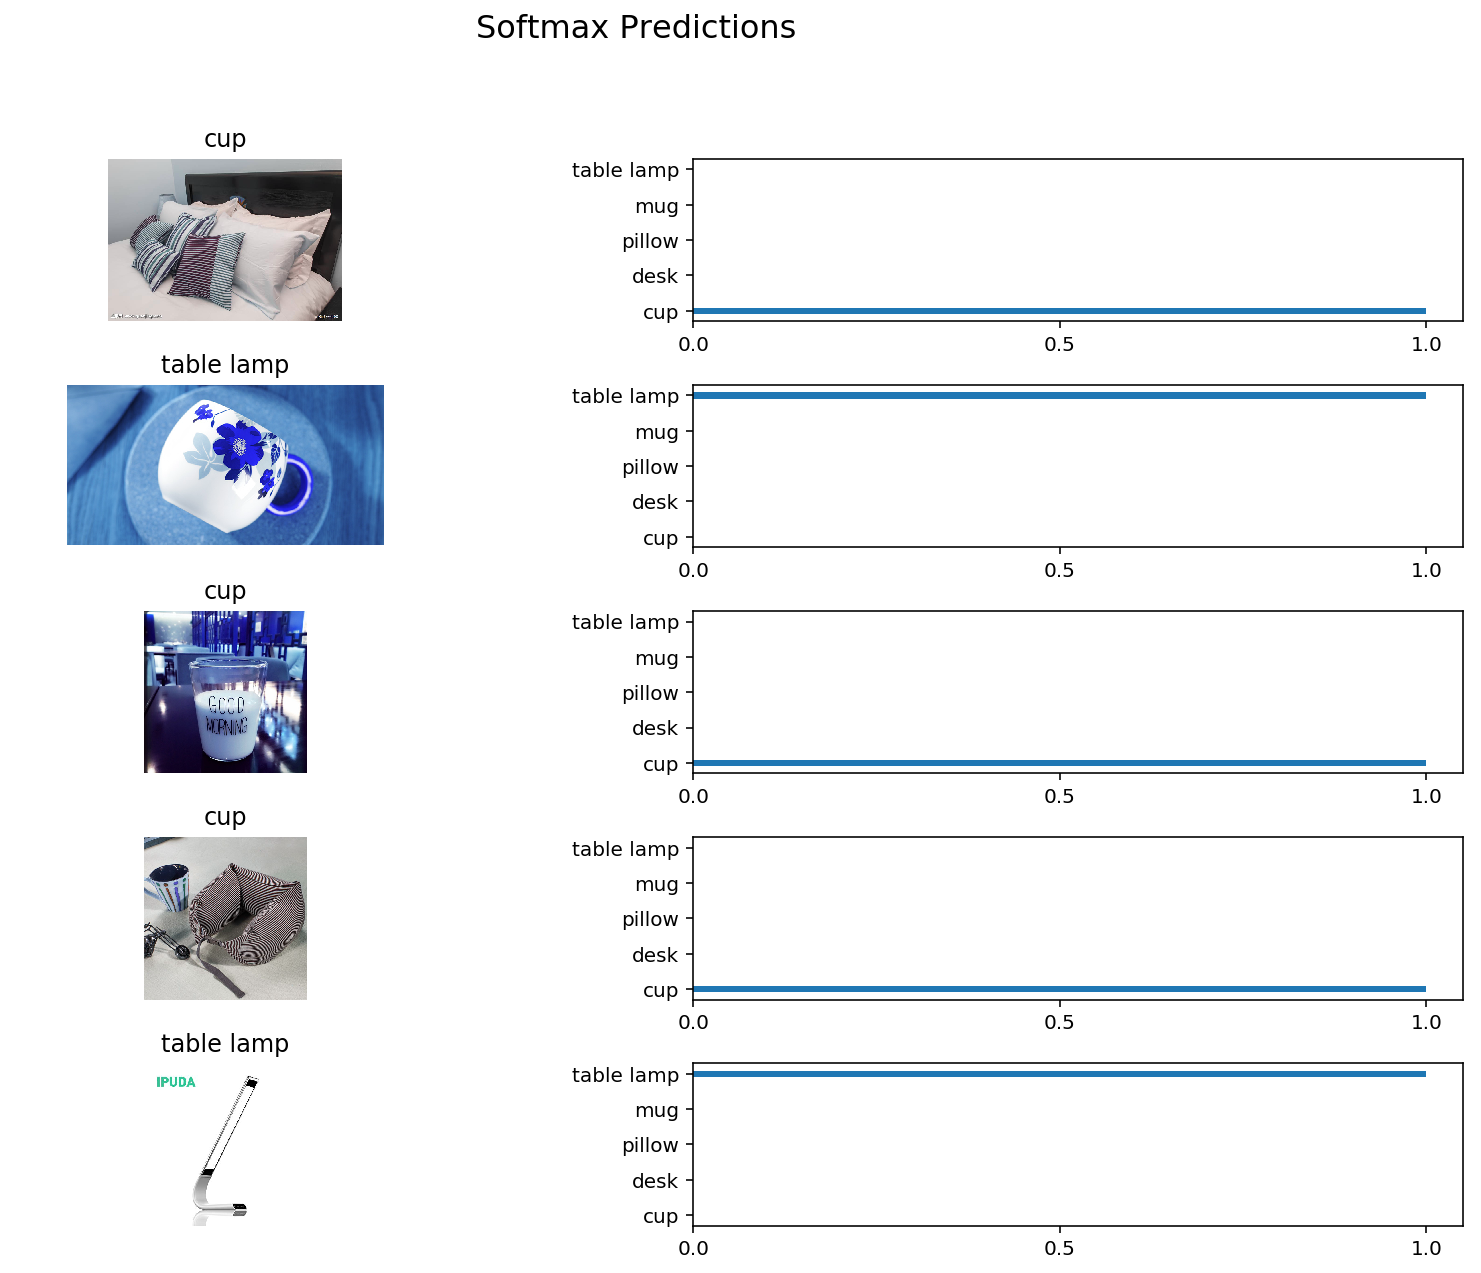

In [24]:
random_predict_and_display(5)

### Confusion matrix

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix

In [26]:
y_pred = trained_model.predict(dataset.X_test)
y_true = np.argmax(dataset.y_test, axis=1)

In [27]:
cnf_matrix = confusion_matrix(y_true, y_pred)

Confusion matrix, without normalization
[[66  0  5 18  9]
 [ 5 85  2  2  3]
 [ 9  3 72 13  8]
 [12  0  6 76  8]
 [ 7  7 17 12 56]]


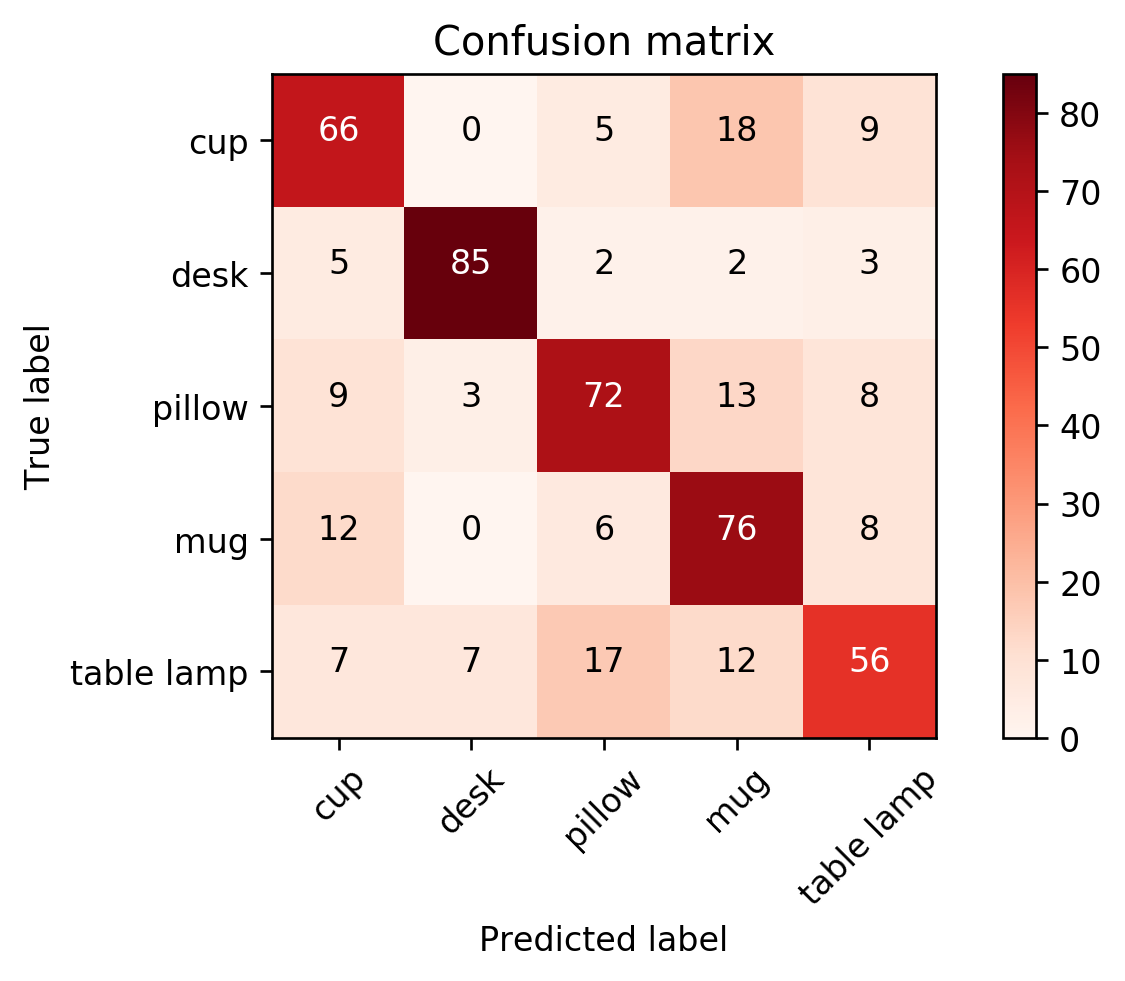

In [28]:
visuals.plot_confusion_matrix(cnf_matrix, classes=class_names, title="Confusion matrix")

Normalized confusion matrix
[[0.67346939 0.         0.05102041 0.18367347 0.09183673]
 [0.05154639 0.87628866 0.02061856 0.02061856 0.03092784]
 [0.08571429 0.02857143 0.68571429 0.12380952 0.07619048]
 [0.11764706 0.         0.05882353 0.74509804 0.07843137]
 [0.07070707 0.07070707 0.17171717 0.12121212 0.56565657]]


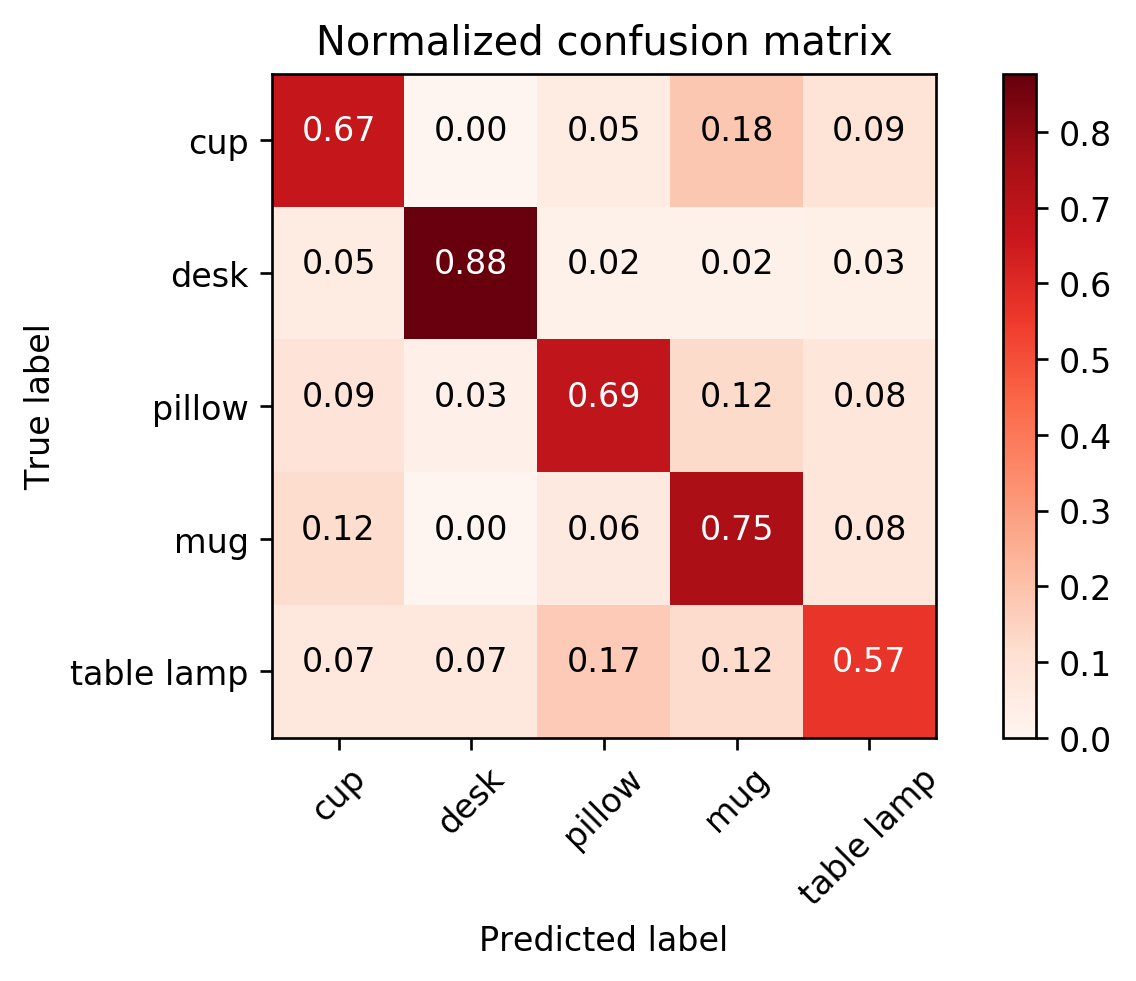

In [29]:
visuals.plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                              title="Normalized confusion matrix")

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.67      0.67      0.67        98
          1       0.89      0.88      0.89        97
          2       0.71      0.69      0.70       105
          3       0.63      0.75      0.68       102
          4       0.67      0.57      0.61        99

avg / total       0.71      0.71      0.71       501

